In [167]:
### Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
from scipy.fftpack import fft, fftfreq
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.filters.hp_filter import hpfilter
import pywt

### Load and Preprocess the Dataset
# Load the dataset
df = pd.read_excel("/Users/elvinanosrati/Capstone/Amberd.xlsx")

In [168]:
print(df.head())
print(df.columns)


        Date      Time  Hour Index  Energy Production (kWh)  Station
0 2022-01-01  01:00:00           1                   182.28  Amberd1
1 2022-01-01  02:00:00           2                   183.12  Amberd1
2 2022-01-01  03:00:00           3                   179.76  Amberd1
3 2022-01-01  04:00:00           4                   178.92  Amberd1
4 2022-01-01  05:00:00           5                   179.76  Amberd1
Index(['Date', 'Time', 'Hour Index', 'Energy Production (kWh)', 'Station'], dtype='object')


In [169]:


# Convert "Date" and "Time" into a single DateTime column
df["DateTime"] = pd.to_datetime(df["Date"].astype(str) + " " + df["Time"].astype(str), errors="coerce")

# Set "DateTime" as the index
df.set_index("DateTime", inplace=True)

# Drop old "Date" and "Time" columns
df.drop(columns=["Date", "Time"], inplace=True)

# Drop "Hour Index" since it's irrelevant for daily aggregation
df.drop(columns=["Hour Index"], inplace=True)

# Convert energy production column to numeric

df["Energy Production (kWh)"] = pd.to_numeric(df["Energy Production (kWh)"], errors="coerce")

# Interpolate missing values BEFORE resampling (to ensure smooth daily aggregation)
df["Energy Production (kWh)"] = df["Energy Production (kWh)"].interpolate(method="linear")

#Convert Hourly Data to Daily Data
df_daily = df.groupby("Station").resample("D").sum(numeric_only=True).reset_index()

### Create a Clean Residuals DataFrame
df_residuals = pd.DataFrame(index=df_daily.index)
df_residuals["Station"] = df_daily["Station"]
df_residuals["STL_Residuals"] = np.nan
df_residuals["Diff_Residuals"] = np.nan
df_residuals["HP_Residuals"] = np.nan
df_residuals["Fourier_Residuals"] = np.nan
df_residuals["Wavelet_Residuals"] = np.nan


In [171]:
print(df_daily.head())  
print(df_daily.columns)

    Station   DateTime  Energy Production (kWh)
0  Amberd 3 2022-01-01                 12693.38
1  Amberd 3 2022-01-02                 13652.38
2  Amberd 3 2022-01-03                 12507.04
3  Amberd 3 2022-01-04                 14888.44
4  Amberd 3 2022-01-05                 13641.18
Index(['Station', 'DateTime', 'Energy Production (kWh)'], dtype='object')


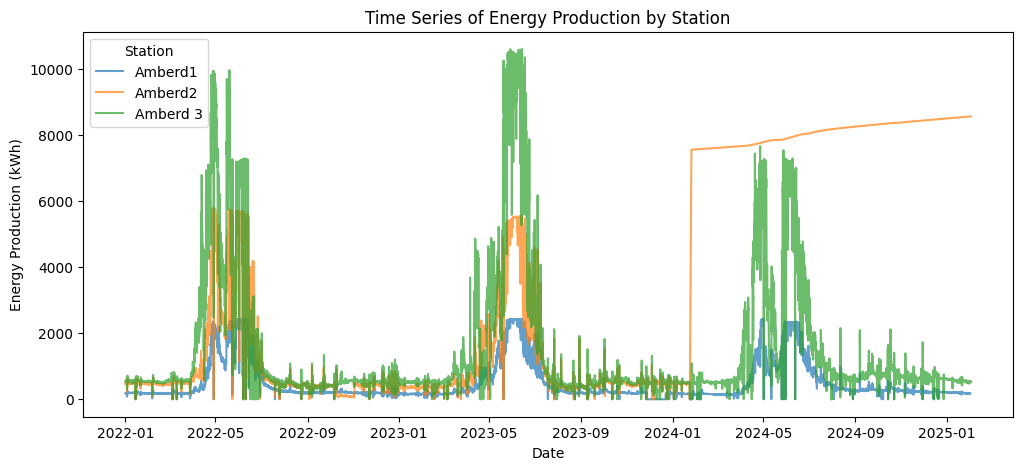

In [172]:
### Time Series Visualization
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x=df.index, y=df["Energy Production (kWh)"].fillna(0), hue="Station", alpha=0.7)
plt.title("Time Series of Energy Production by Station")
plt.xlabel("Date")
plt.ylabel("Energy Production (kWh)")
plt.legend(title="Station")
plt.show()

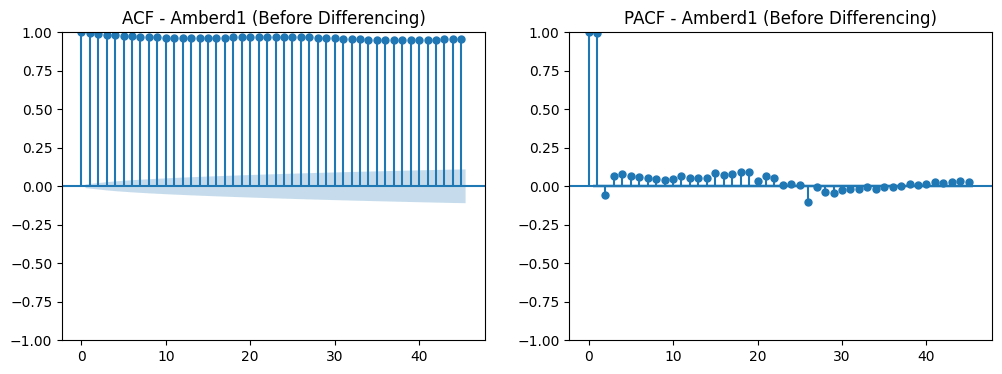

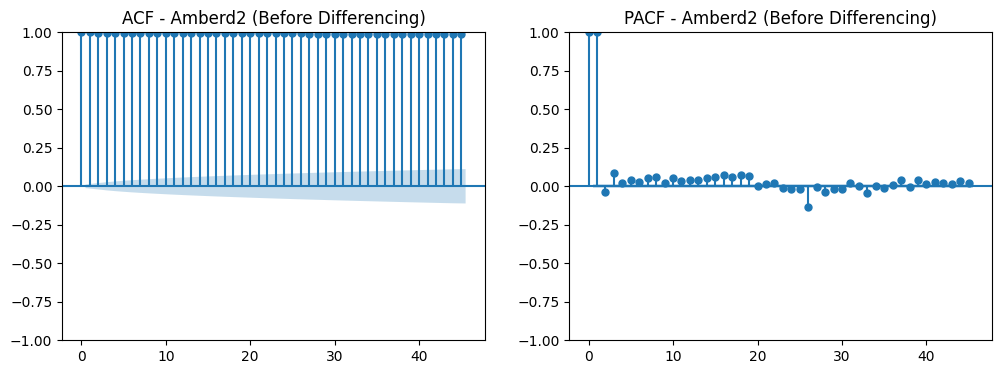

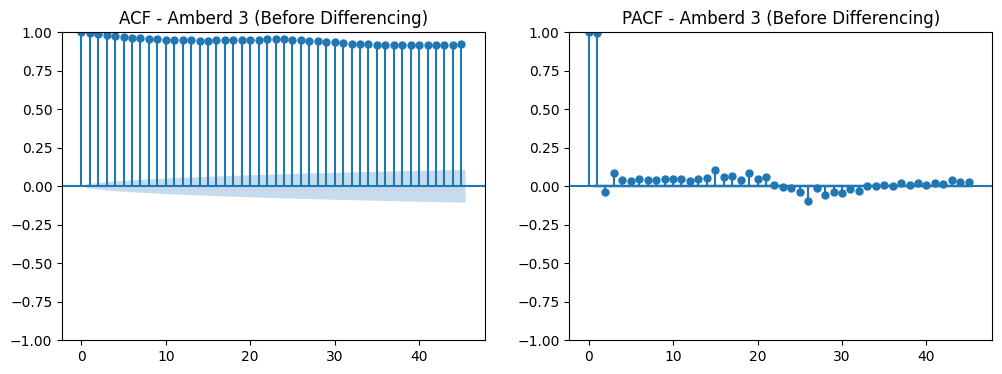

In [121]:
### ACF and PACF Plots (Before Differencing)
for station in df["Station"].unique():
    station_data = df.loc[df["Station"] == station, "Energy Production (kWh)"].dropna()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(station_data, ax=axes[0], title=f"ACF - {station} (Before Differencing)")
    plot_pacf(station_data, ax=axes[1], title=f"PACF - {station} (Before Differencing)")
    plt.show()


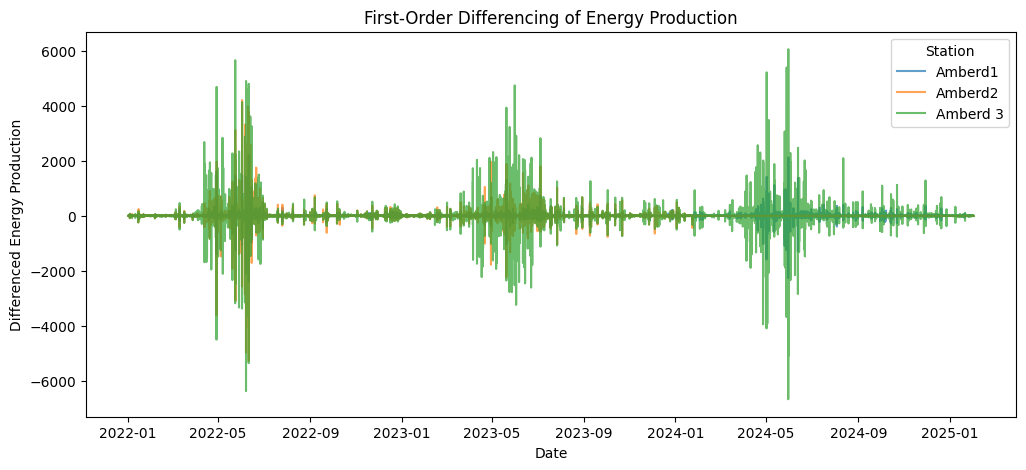

In [137]:
### First-Order Differencing
df["Diff_Production"] = df.groupby("Station")["Energy Production (kWh)"].diff()
df.dropna(subset=["Diff_Production"], inplace=True)


plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x=df.index, y="Diff_Production", hue="Station", alpha=0.7)
plt.title("First-Order Differencing of Energy Production")
plt.xlabel("Date")
plt.ylabel("Differenced Energy Production")
plt.legend(title="Station")
plt.show()



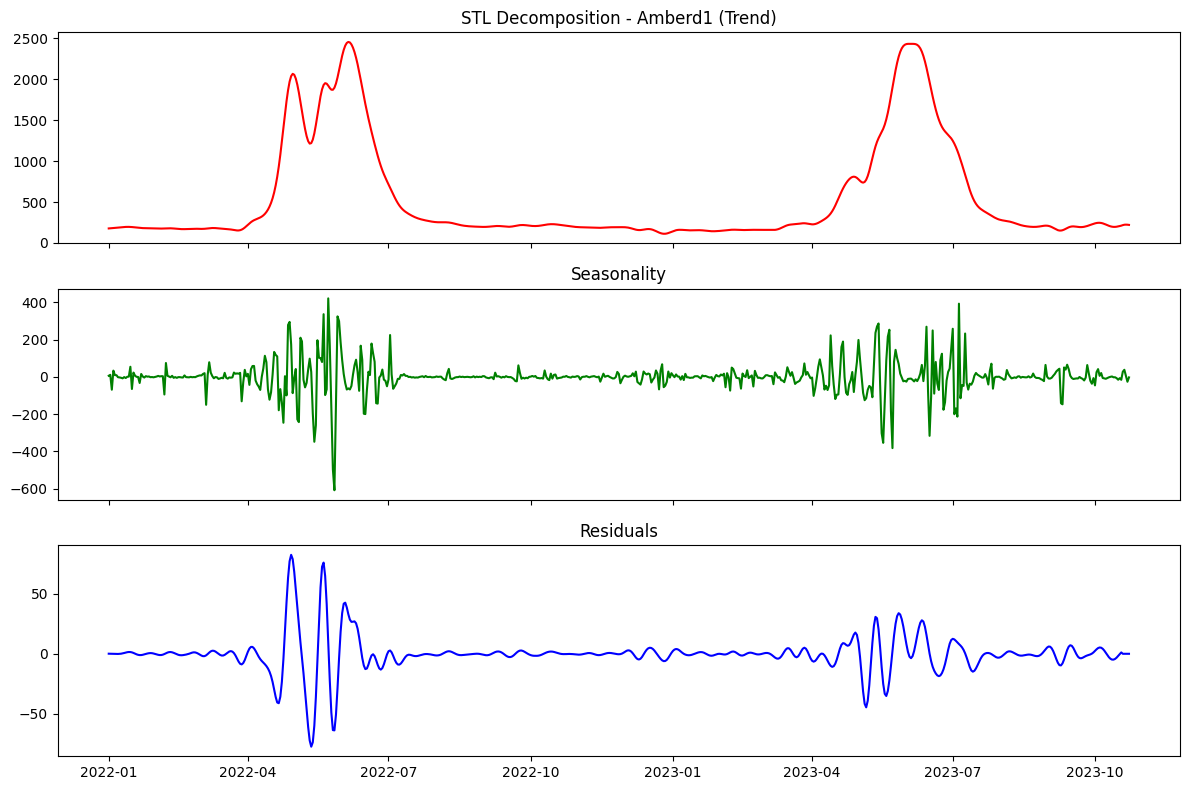

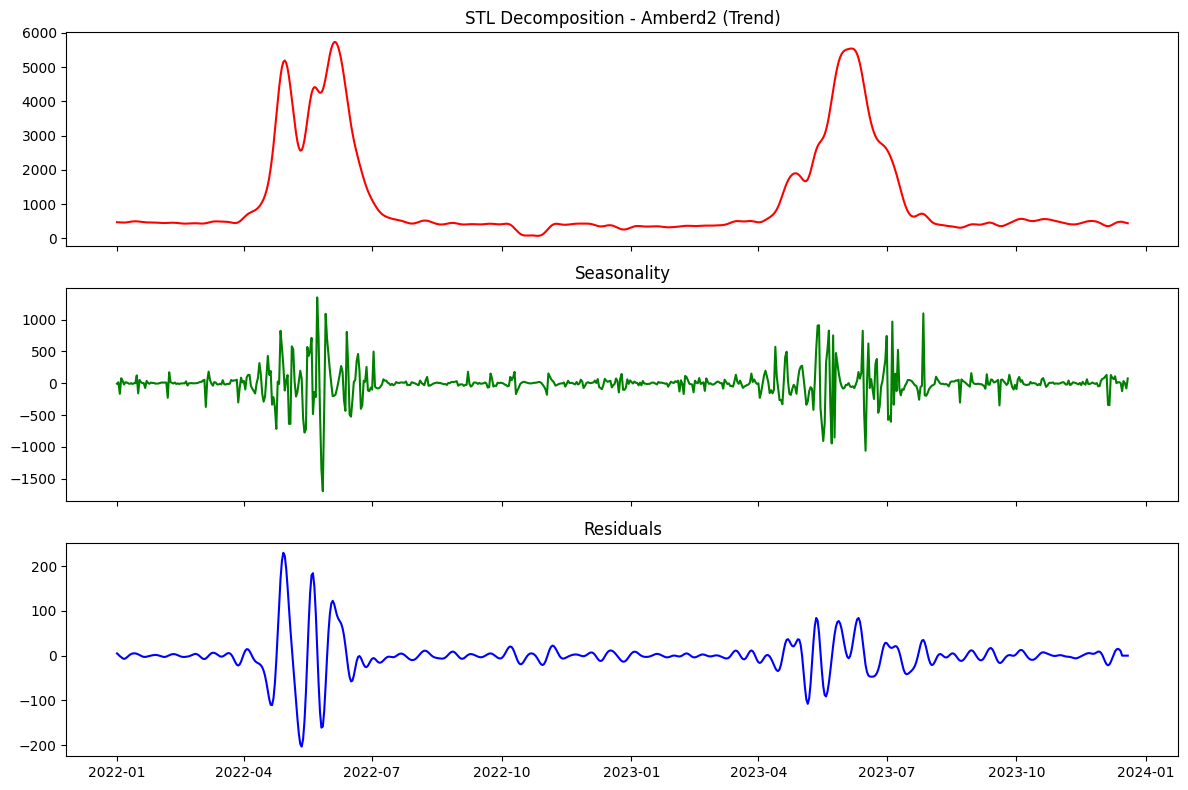

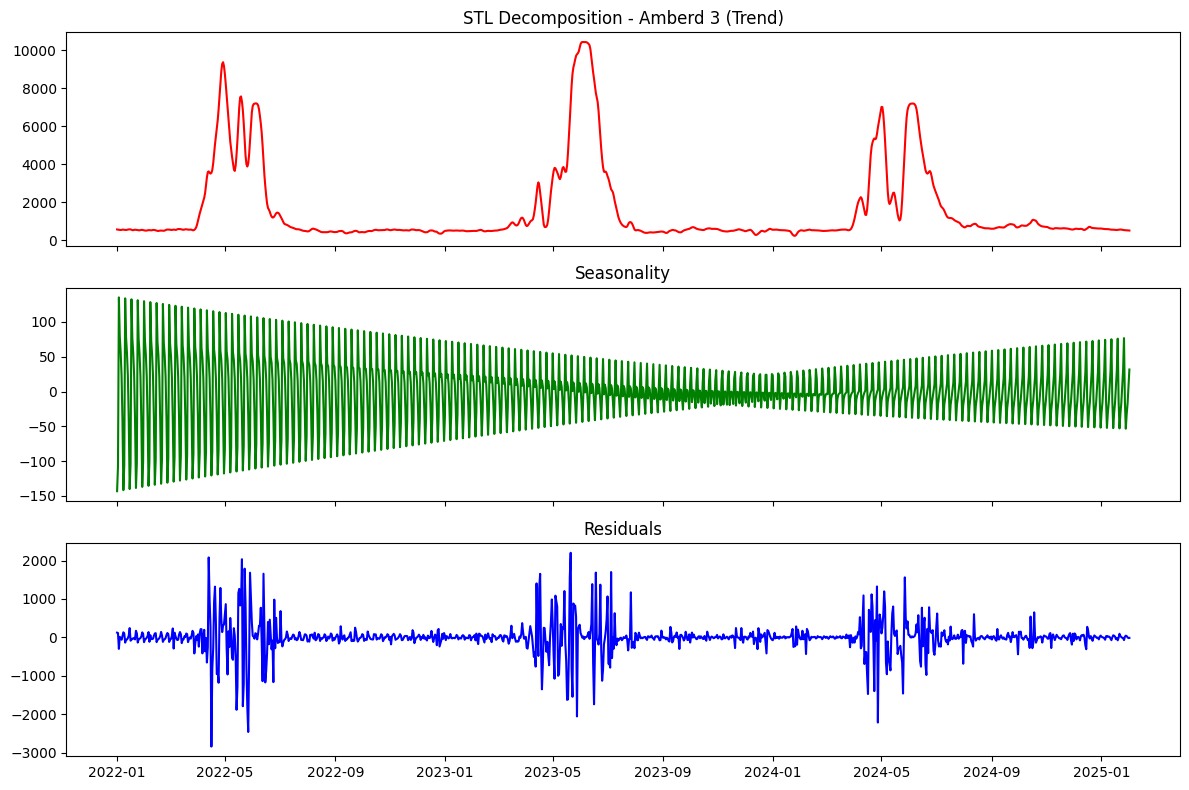

In [131]:
### STL Decomposition with 365-day Seasonality
for station in df["Station"].unique():
    station_data = df[df["Station"] == station]["Energy Production (kWh)"].copy()
    station_data = station_data.asfreq("D")
    stl = STL(station_data, seasonal=365)
    result = stl.fit()
    
    # Store residuals in df_residuals
    df_residuals.loc[df_daily["Station"] == station, "STL_Residuals"] = result.resid

    
    # Plot decomposition
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    axes[0].plot(result.trend, label="Trend", color="red")
    axes[0].set_title(f"STL Decomposition - {station} (Trend)")
    axes[1].plot(result.seasonal, label="Seasonality", color="green")
    axes[1].set_title("Seasonality")
    axes[2].plot(result.resid, label="Residuals", color="blue")
    axes[2].set_title("Residuals")
    plt.tight_layout()
    plt.show()



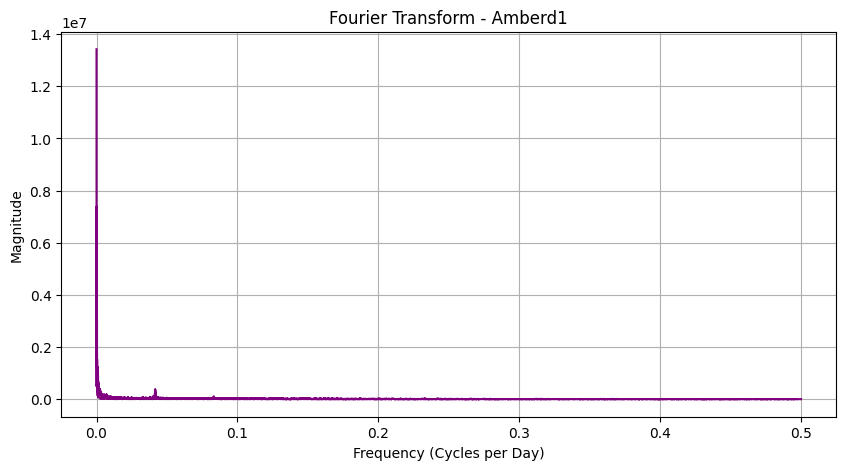

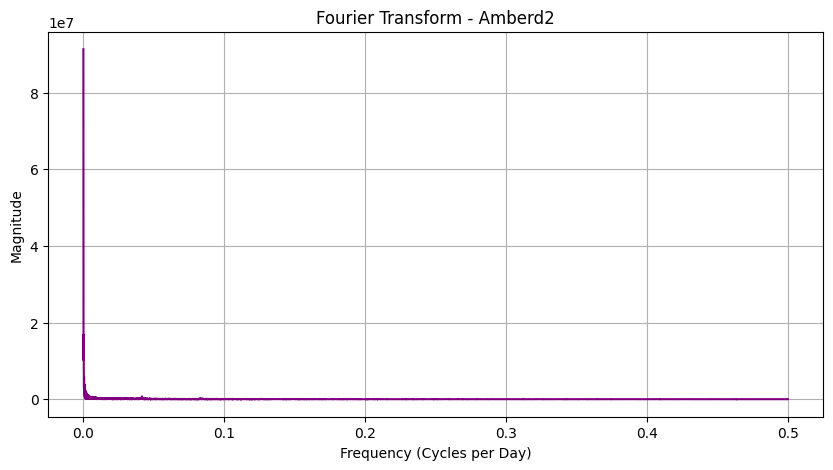

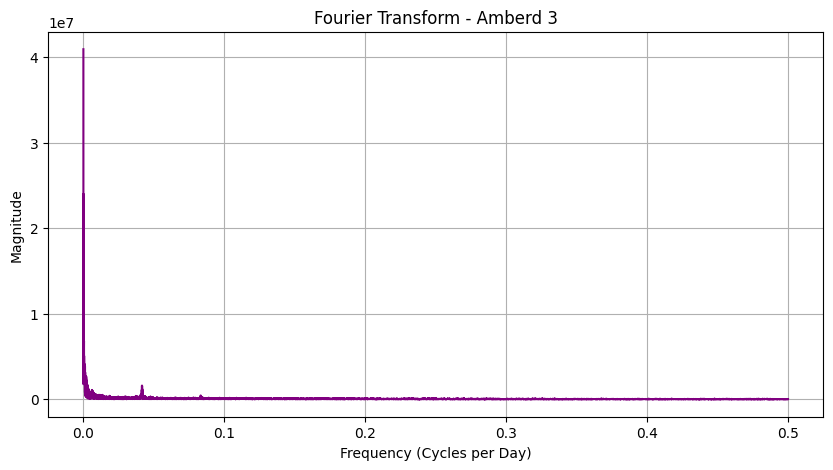

In [39]:
### Fourier Transform
for station in df["Station"].unique():
    station_data = df[df["Station"] == station]["Energy Production (kWh)"].dropna()
    
    N = len(station_data)
    T = 1  # Assuming daily frequency
    fft_result = fft(station_data.values)
    frequencies = fftfreq(N, T)
    positive_freqs = frequencies[:N // 2]
    magnitude = np.abs(fft_result[:N // 2])
    
    plt.figure(figsize=(10, 5))
    plt.plot(positive_freqs, magnitude, color='purple')
    plt.title(f"Fourier Transform - {station}")
    plt.xlabel("Frequency (Cycles per Day)")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.show()




/Users/elvinanosrati/jupyter_env/lib/python3.13/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


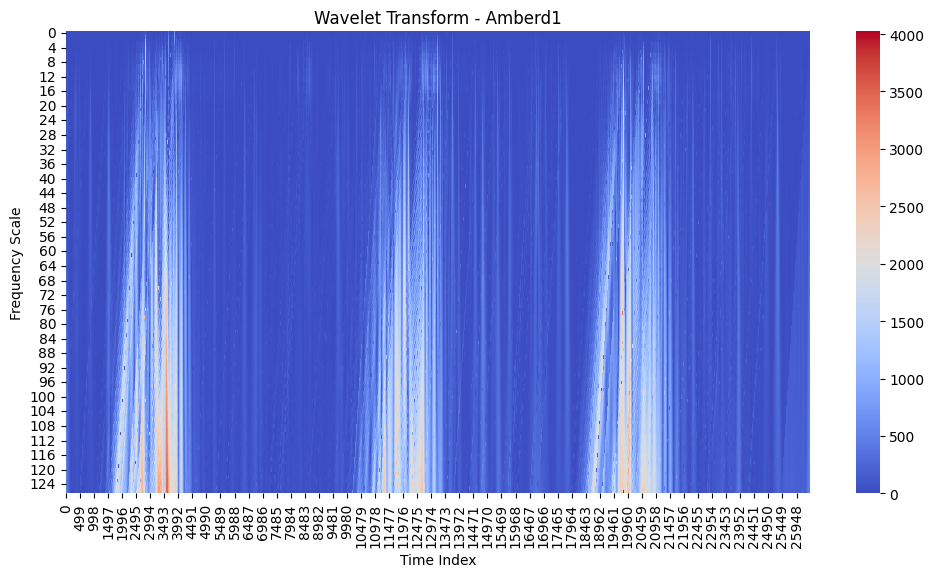

/Users/elvinanosrati/jupyter_env/lib/python3.13/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


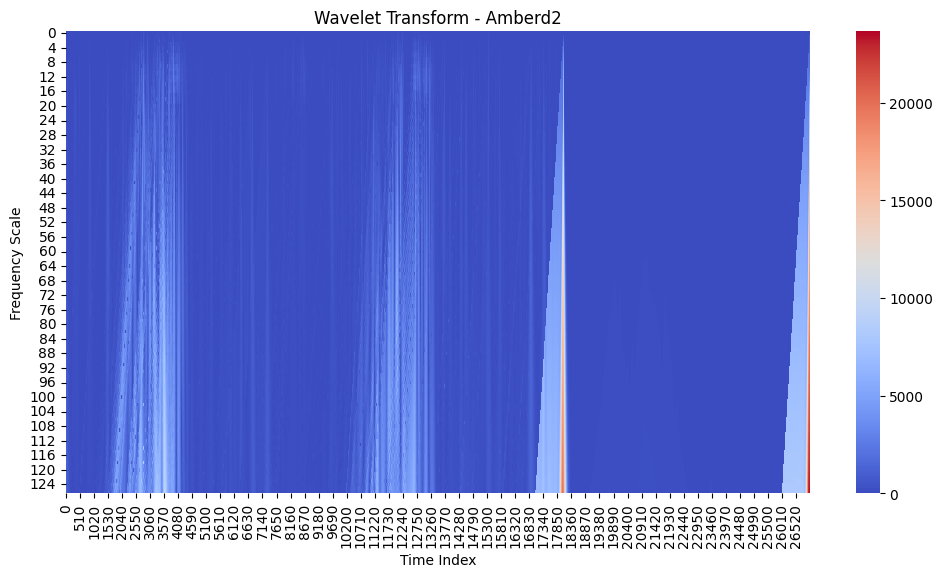

/Users/elvinanosrati/jupyter_env/lib/python3.13/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


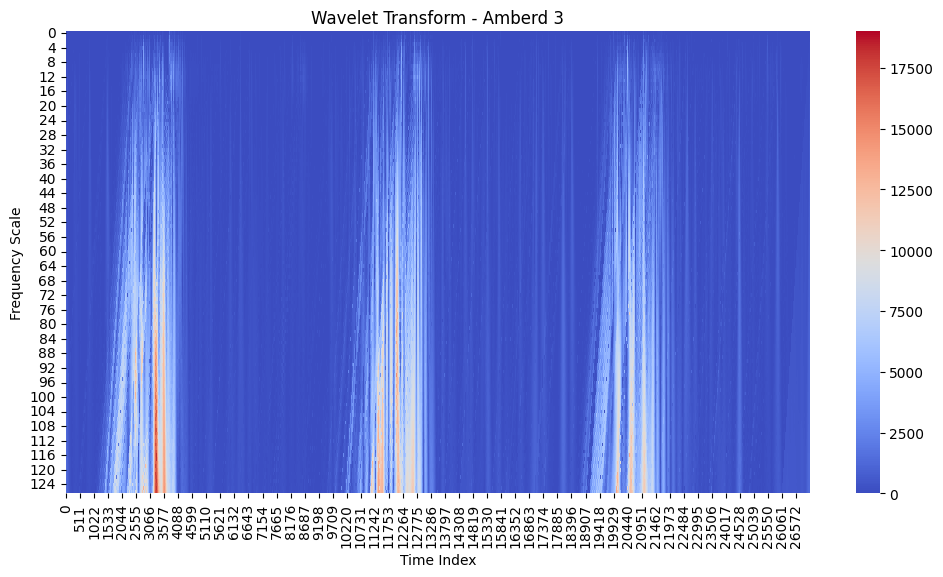

In [40]:
### Wavelet Transform
for station in df["Station"].unique():
    station_data = df[df["Station"] == station]["Energy Production (kWh)"].dropna()
    scales = np.arange(1, 128)
    wavelet_name = 'cmor'
    coefficients, frequencies = pywt.cwt(station_data, scales, wavelet_name)
    plt.figure(figsize=(12, 6))
    sns.heatmap(np.abs(coefficients), cmap="coolwarm", cbar=True)
    plt.title(f"Wavelet Transform - {station}")
    plt.xlabel("Time Index")
    plt.ylabel("Frequency Scale")
    plt.show()


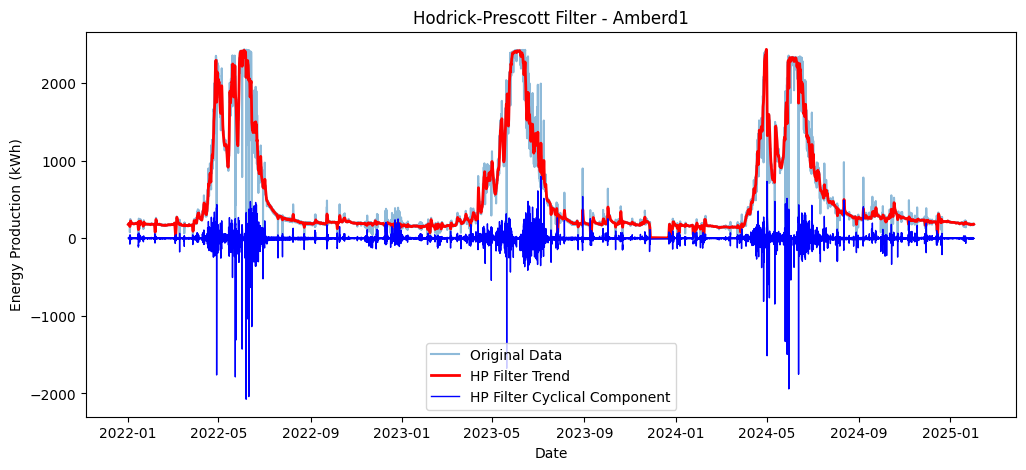

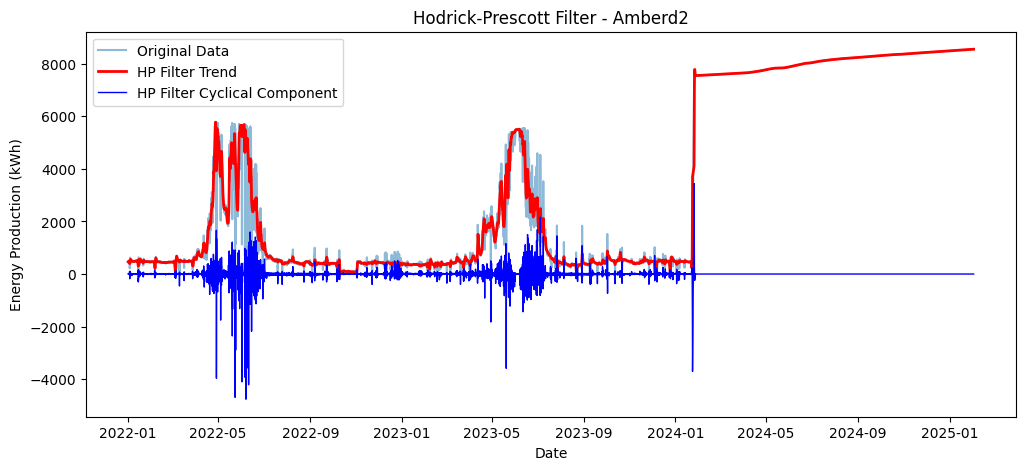

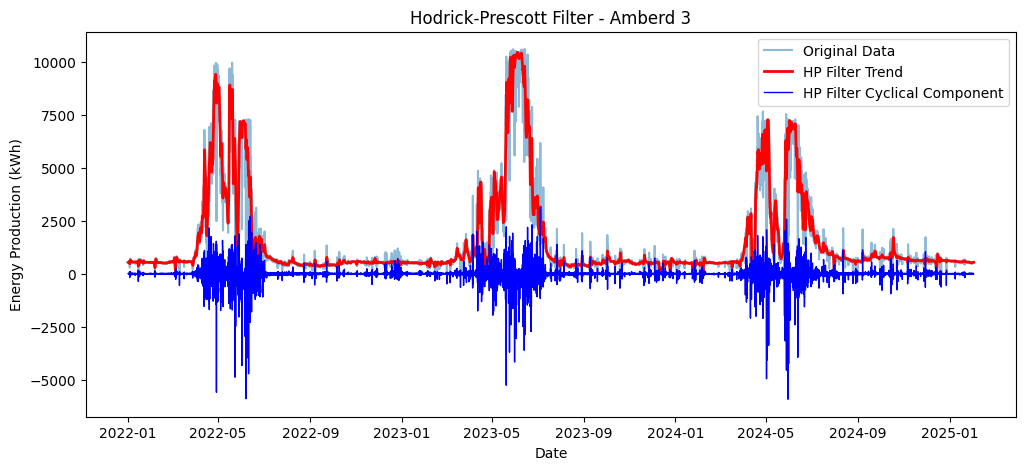

In [41]:
### Hodrick-Prescott Filter
for station in df["Station"].unique():
    station_data = df[df["Station"] == station]["Energy Production (kWh)"].dropna()
    cycle, trend = hpfilter(station_data, lamb=1600)
    plt.figure(figsize=(12, 5))
    plt.plot(station_data.index, station_data, label="Original Data", alpha=0.5)
    plt.plot(station_data.index, trend, label="HP Filter Trend", color="red", linewidth=2)
    plt.plot(station_data.index, cycle, label="HP Filter Cyclical Component", color="blue", linewidth=1)
    plt.title(f"Hodrick-Prescott Filter - {station}")
    plt.xlabel("Date")
    plt.ylabel("Energy Production (kWh)")
    plt.legend()
    plt.show()
